In [2]:
import h5py
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

In [3]:
with h5py.File('../data/lotka_volterra_data.h5', 'r') as f:
    trajectories = f['trajectories'][:]  # Shape: (1000, 100, 2)
    time_points = f['time'][:]           # Shape: (100,)
    
    print("Dataset shape:", trajectories.shape)
    print("Time points shape:", time_points.shape)
    print("First few time points:", time_points[-5:])



Dataset shape: (1000, 100, 2)
Time points shape: (100,)
First few time points: [191.91919192 193.93939394 195.95959596 197.97979798 200.        ]


## Sample trajectories of prey and predator populations over time

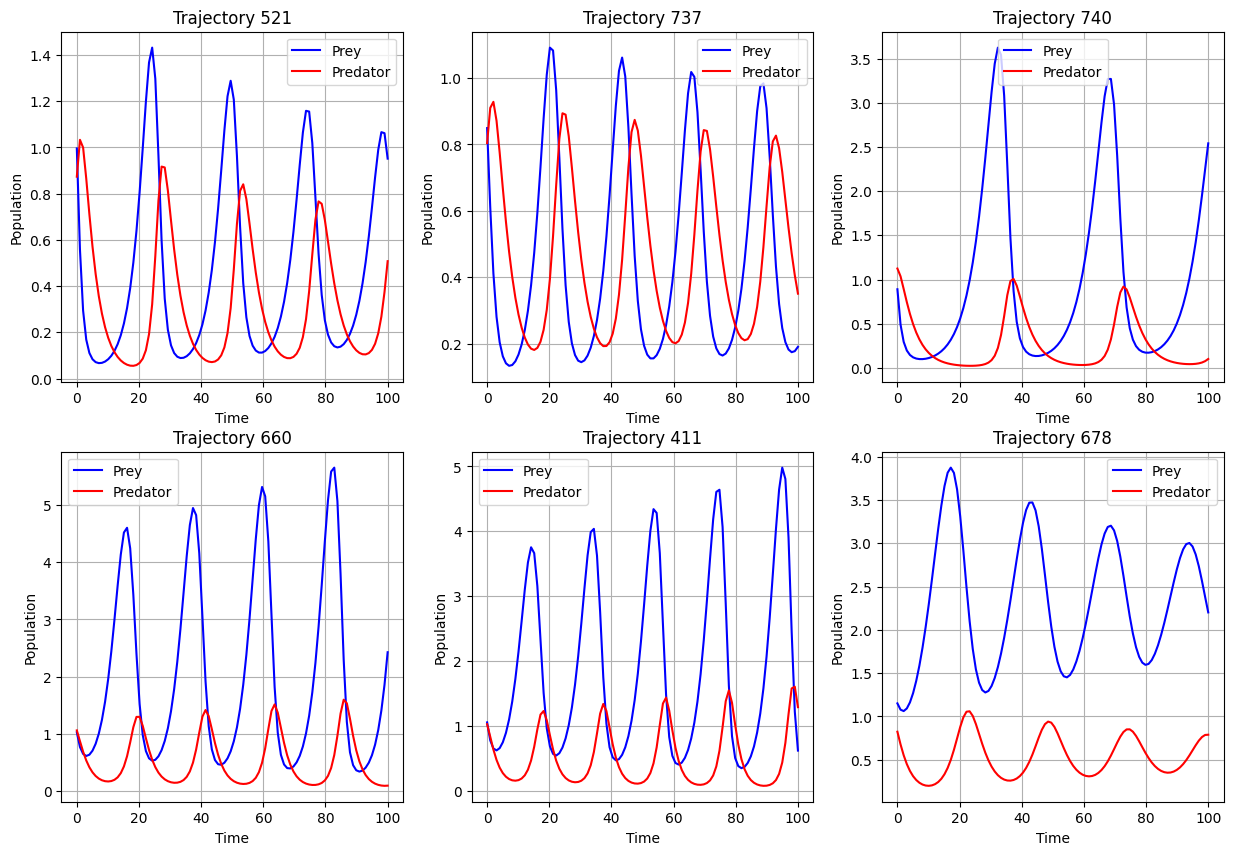

In [4]:
# Plot a few example trajectories
plt.figure(figsize=(15, 10))

# Plot 5 random trajectories
np.random.seed(42)  # For reproducibility
sample_indices = np.random.choice(trajectories.shape[0], 6, replace=False)
time_points = np.linspace(0, 100, trajectories.shape[1])

for i, idx in enumerate(sample_indices):
    plt.subplot(2, 3, i+1)
    plt.plot(time_points,trajectories[idx, :, 0], 'b-', label='Prey')
    plt.plot(time_points,trajectories[idx, :, 1], 'r-', label='Predator')
    plt.title(f'Trajectory {idx}')
    plt.xlabel('Time')
    plt.ylabel('Population')
    plt.legend()
    plt.grid(True)

## Phase portrait showing the relationship between prey and predator populations

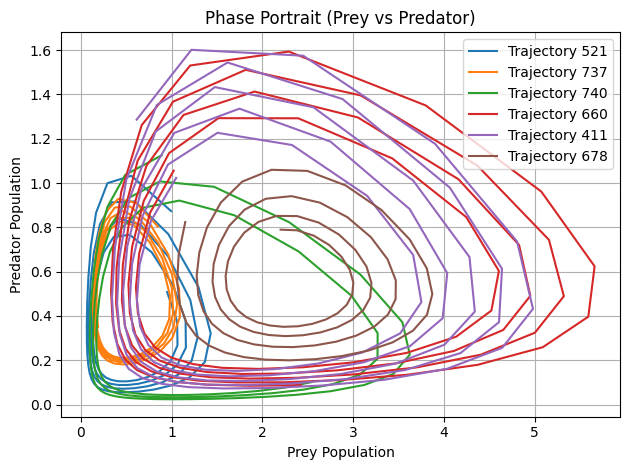

In [5]:
# Plot the phase portrait for the first example
for idx in sample_indices:
    plt.plot(trajectories[idx, :, 0], trajectories[idx, :, 1])
plt.title('Phase Portrait (Prey vs Predator)')
plt.xlabel('Prey Population')
plt.ylabel('Predator Population')
plt.legend([f'Trajectory {idx}' for idx in sample_indices])
plt.grid(True)

plt.tight_layout()
plt.show()


In [6]:
#test the max and min for all trajectories
max_prey = np.max(trajectories[:,:,0])
min_prey = np.min(trajectories[:,:,0])
max_pred = np.max(trajectories[:,:,1])
min_pred = np.min(trajectories[:,:,1])
print("Max prey:", max_prey)
print("Min prey:", min_prey)    
print("Max predator:", max_pred)
print("Min predator:", min_pred)

Max prey: 13.740113
Min prey: 0.0020773283
Max predator: 4.7684903
Min predator: 3.7355094e-05


In [7]:
# Calculate statistics across all trajectories
prey_mean = np.mean(trajectories[:, :, 0], axis=0)
prey_std = np.std(trajectories[:, :, 0], axis=0)
pred_mean = np.mean(trajectories[:, :, 1], axis=0)
pred_std = np.std(trajectories[:, :, 1], axis=0)

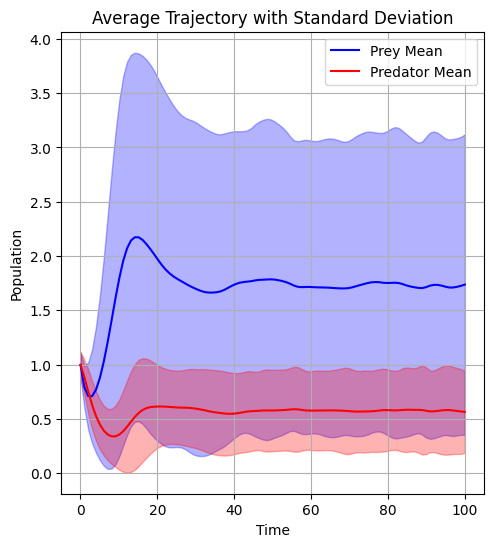

In [8]:
# Plot the average trajectory with standard deviation
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(time_points, prey_mean, 'b-', label='Prey Mean')
plt.fill_between(time_points, prey_mean - prey_std, prey_mean + prey_std, alpha=0.3, color='blue')
plt.plot(time_points, pred_mean, 'r-', label='Predator Mean')
plt.fill_between(time_points, pred_mean - pred_std, pred_mean + pred_std, alpha=0.3, color='red')
plt.title('Average Trajectory with Standard Deviation')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.grid(True)


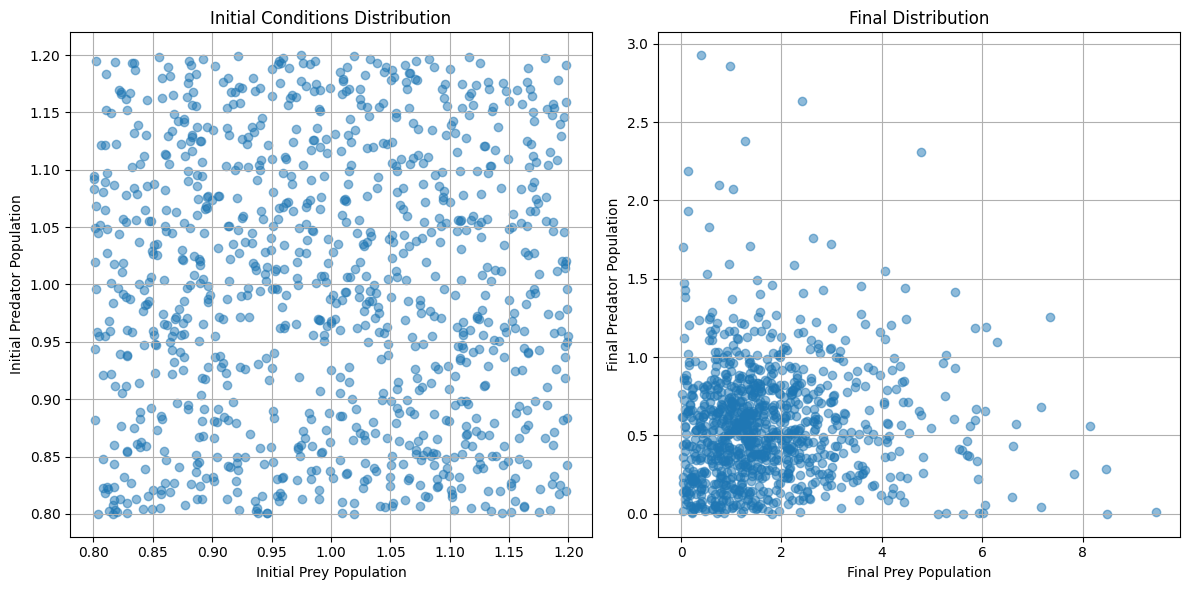

In [23]:
# Plot distribution of initial conditions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(trajectories[:, 0, 0], trajectories[:, 0, 1], alpha=0.5)
plt.title('Initial Conditions Distribution')
plt.xlabel('Initial Prey Population')
plt.ylabel('Initial Predator Population')
plt.grid(True)

# Plot distribution of initial conditions
plt.subplot(1, 2, 2)
plt.scatter(trajectories[:, -1, 0], trajectories[:, -1, 1], alpha=0.5)
plt.title('Final Distribution')
plt.xlabel('Final Prey Population')
plt.ylabel('Final Predator Population')
plt.grid(True)

plt.tight_layout()
plt.show()

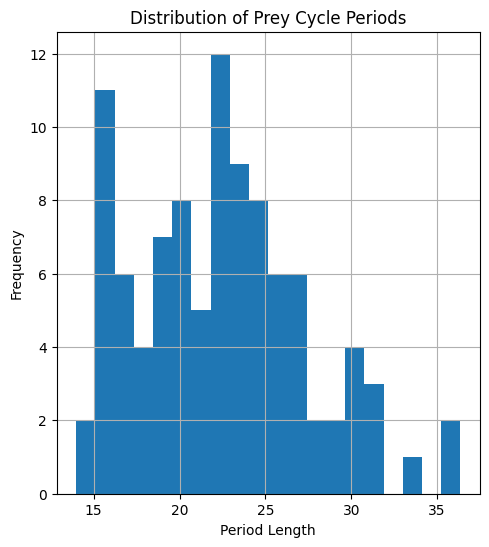

In [11]:
plt.figure(figsize=(12, 6))

# Find periods for prey populations
periods = []
for i in range(min(100, trajectories.shape[0])):  # Use first 100 trajectories
    # Find peaks
    peaks, _ = find_peaks(trajectories[i, :, 0], height=0)
    if len(peaks) >= 2:
        # Calculate average distance between peaks
        peak_diffs = np.diff(peaks)
        period = np.mean(peak_diffs) * (time_points[1] - time_points[0])
        periods.append(period)

plt.subplot(1, 2, 1)
plt.hist(periods, bins=20)
plt.title('Distribution of Prey Cycle Periods')
plt.xlabel('Period Length')
plt.ylabel('Frequency')
plt.grid(True)


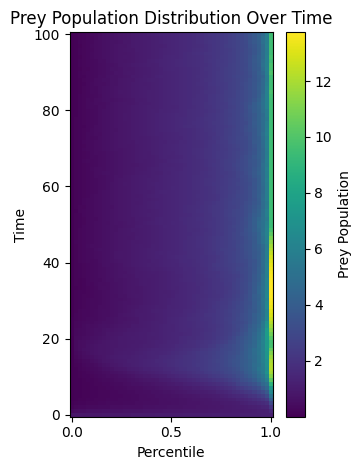

In [12]:
# Plot a heatmap of population dynamics over time
plt.subplot(1, 2, 2)
plt.pcolormesh(np.linspace(0, 1, 50), time_points, 
               np.percentile(trajectories[:, :, 0], np.linspace(0, 100, 50), axis=0).T)
plt.title('Prey Population Distribution Over Time')
plt.xlabel('Percentile')
plt.ylabel('Time')
plt.colorbar(label='Prey Population')

plt.tight_layout()
plt.show()

In [13]:
#check whether we have duplicate trajectories
unique_trajectories = np.unique(trajectories, axis=0)
num_duplicates = trajectories.shape[0] - unique_trajectories.shape[0]
print("Number of duplicate trajectories:", num_duplicates)

Number of duplicate trajectories: 0


In [14]:
#find correlation between prey and predator
correlations = np.corrcoef(trajectories[:, :, 0].flatten(), trajectories[:, :, 1].flatten())
print("Correlation between Prey and Predator:", correlations[0, 1]) 

Correlation between Prey and Predator: 0.02722648872279597


In [15]:
# Check for corrupted labels
corrupted_indices = [] 
for i in range(trajectories.shape[0]):
    if np.any(trajectories[i] < 0):
        corrupted_indices.append(i)
        print(f"Corrupted trajectory found at index {i}") 
        print(trajectories[i])

## Dynamics Exploration

In [16]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from sklearn.cluster import KMeans
import os
from tqdm import tqdm
    

In [17]:
with h5py.File('../data/lotka_volterra_data.h5', "r") as f:
        trajectories = f["trajectories"][:]  # Shape: (1000, 100, 2)
        time_points = f["time"][:]  # Shape: (100,)
    
num_systems = trajectories.shape[0]
print(f"Analyzing {num_systems} predator-prey systems...")

Analyzing 1000 predator-prey systems...


In [18]:
save_path='../results/data_analysis'

In [19]:
os.makedirs(save_path, exist_ok=True)
plots_dir = os.path.join(save_path, "system_plots")
os.makedirs(plots_dir, exist_ok=True)

In [20]:
# Initialize result structures
all_metrics = []
all_prey_periods = []
all_predator_periods = []
all_phase_diffs = []
features_for_clustering = []

# Process each trajectory
for idx in tqdm(range(num_systems)):
    trajectory = trajectories[idx]
    prey = trajectory[:, 0]
    predator = trajectory[:, 1]
    
    # Find peaks to analyze oscillation
    prey_peaks, _ = find_peaks(prey)
    predator_peaks, _ = find_peaks(predator)
    
    # Calculate periods if enough peaks exist
    prey_period = np.mean(np.diff(prey_peaks)) if len(prey_peaks) > 1 else np.nan
    predator_period = np.mean(np.diff(predator_peaks)) if len(predator_peaks) > 1 else np.nan
    
    # Analyze phase relationship if both have peaks
    if len(prey_peaks) > 0 and len(predator_peaks) > 0:
        # Find closest predator peak to first prey peak
        first_prey_peak = prey_peaks[0]
        closest_pred_peak_idx = np.argmin(np.abs(predator_peaks - first_prey_peak))
        closest_pred_peak = predator_peaks[closest_pred_peak_idx]
        
        # Calculate phase difference (normalized to 0-1)
        avg_period = (prey_period + predator_period) / 2 if not np.isnan(prey_period) and not np.isnan(predator_period) else np.nan
        phase_diff = abs(first_prey_peak - closest_pred_peak) / avg_period if not np.isnan(avg_period) else np.nan
        
        if not np.isnan(phase_diff):
            all_phase_diffs.append(phase_diff)
    else:
        phase_diff = np.nan
    
    # Calculate amplitude and other statistics
    prey_amplitude = (np.max(prey) - np.min(prey)) / 2 if len(prey) > 0 else np.nan
    predator_amplitude = (np.max(predator) - np.min(predator)) / 2 if len(predator) > 0 else np.nan
    
    # Calculate trend (growing or decaying oscillations)
    if len(prey_peaks) > 1:
        prey_peak_values = prey[prey_peaks]
        prey_trend = np.polyfit(np.arange(len(prey_peak_values)), prey_peak_values, 1)[0]
    else:
        prey_trend = np.nan
        
    if len(predator_peaks) > 1:
        predator_peak_values = predator[predator_peaks]
        predator_trend = np.polyfit(np.arange(len(predator_peak_values)), predator_peak_values, 1)[0]
    else:
        predator_trend = np.nan
    
    # Store metrics for this system
    metrics = {
        "index": int(idx),
        "prey_period": float(prey_period) if not np.isnan(prey_period) else None,
        "predator_period": float(predator_period) if not np.isnan(predator_period) else None,
        "phase_difference": float(phase_diff) if not np.isnan(phase_diff) else None,
        "prey_max": float(np.max(prey)),
        "prey_min": float(np.min(prey)),
        "predator_max": float(np.max(predator)),
        "predator_min": float(np.min(predator)),
        "prey_amplitude": float(prey_amplitude) if not np.isnan(prey_amplitude) else None,
        "predator_amplitude": float(predator_amplitude) if not np.isnan(predator_amplitude) else None,
        "prey_trend": float(prey_trend) if not np.isnan(prey_trend) else None,
        "predator_trend": float(predator_trend) if not np.isnan(predator_trend) else None,
        "correlation": float(np.corrcoef(prey, predator)[0, 1])
    }
    
    all_metrics.append(metrics)
    
    # Collect valid metrics for summary
    if not np.isnan(prey_period):
        all_prey_periods.append(prey_period)
    if not np.isnan(predator_period):
        all_predator_periods.append(predator_period)
    
    # Collect features for clustering
    feature_vector = [
        np.nan_to_num(prey_period, nan=0),
        np.nan_to_num(predator_period, nan=0),
        np.nan_to_num(phase_diff, nan=0),
        prey_amplitude if not np.isnan(prey_amplitude) else 0,
        predator_amplitude if not np.isnan(predator_amplitude) else 0,
        np.nan_to_num(prey_trend, nan=0),
        np.nan_to_num(predator_trend, nan=0),
        metrics["correlation"]
    ]
    features_for_clustering.append(feature_vector)
    
    # Generate and save individual plot (only for a few systems)
    if save_path and idx < 20:  # Only plot first 20 systems to avoid too many files
        fig, ax1 = plt.subplots(figsize=(10, 6))
        
        # Plot prey on left y-axis
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Prey Population', color='g')
        ax1.plot(time_points, prey, 'g-', label='Prey')
        if len(prey_peaks) > 0:
            ax1.plot(time_points[prey_peaks], prey[prey_peaks], 'go')
        ax1.tick_params(axis='y', labelcolor='g')
        
        # Create second y-axis for predator
        ax2 = ax1.twinx()
        ax2.set_ylabel('Predator Population', color='r')
        ax2.plot(time_points, predator, 'r-', label='Predator')
        if len(predator_peaks) > 0:
            ax2.plot(time_points[predator_peaks], predator[predator_peaks], 'ro')
        ax2.tick_params(axis='y', labelcolor='r')
        
        # Add title with metrics
        if metrics['prey_period'] is not None and metrics['predator_period'] is not None and metrics['phase_difference'] is not None:
            plt.title(f"System {idx} - Prey Period: {metrics['prey_period']:.2f}, " + 
                    f"Predator Period: {metrics['predator_period']:.2f}, " +
                    f"Phase Diff: {metrics['phase_difference']:.2f}")
        else:
            # Create a title with only the available metrics
            title_parts = [f"System {idx}"]
            if metrics['prey_period'] is not None:
                title_parts.append(f"Prey Period: {metrics['prey_period']:.2f}")
            if metrics['predator_period'] is not None:
                title_parts.append(f"Predator Period: {metrics['predator_period']:.2f}")
            if metrics['phase_difference'] is not None:
                title_parts.append(f"Phase Diff: {metrics['phase_difference']:.2f}")
            
            plt.title(" - ".join(title_parts))
        
        fig.tight_layout()
        plt.savefig(os.path.join(plots_dir, f"system_{idx}.png"))
        plt.close(fig)
        
        # Create phase diagram
        plt.figure(figsize=(8, 6))
        plt.plot(prey, predator)
        plt.scatter(prey[0], predator[0], marker='o', color='black', label='Start')
        plt.xlabel("Prey Population")
        plt.ylabel("Predator Population")
        plt.title(f"Phase Diagram - System {idx}")
        plt.grid(True)
        plt.savefig(os.path.join(plots_dir, f"phase_system_{idx}.png"))
        plt.close()

100%|██████████| 1000/1000 [00:03<00:00, 294.67it/s]


In [21]:
# Cluster the systems
features_array = np.array(features_for_clustering)
# Normalize features for clustering
features_mean = np.mean(features_array, axis=0)
features_std = np.std(features_array, axis=0)
features_normalized = (features_array - features_mean) / (features_std + 1e-10)

# Determine optimal number of clusters using silhouette score
from sklearn.metrics import silhouette_score
silhouette_scores = []
K_range = range(2, min(11, num_systems // 10 + 1))  # Try 2-10 clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(features_normalized)
    score = silhouette_score(features_normalized, labels)
    silhouette_scores.append(score)

# Choose optimal k
optimal_k = K_range[np.argmax(silhouette_scores)]

# Apply clustering with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(features_normalized)

# Add cluster labels to metrics
for i, metrics in enumerate(all_metrics):
    metrics["cluster"] = int(cluster_labels[i])

# Compute summary statistics by cluster
cluster_summaries = {}
for cluster in range(optimal_k):
    cluster_metrics = [m for m in all_metrics if m["cluster"] == cluster]
    
    if not cluster_metrics:
        continue
        
    cluster_summaries[f"cluster_{cluster}"] = {
        "count": len(cluster_metrics),
        "percentage": len(cluster_metrics) / len(all_metrics) * 100,
        "avg_prey_period": np.nanmean([m["prey_period"] for m in cluster_metrics if m["prey_period"] is not None]),
        "avg_predator_period": np.nanmean([m["predator_period"] for m in cluster_metrics if m["predator_period"] is not None]),
        "avg_phase_difference": np.nanmean([m["phase_difference"] for m in cluster_metrics if m["phase_difference"] is not None]),
        "avg_prey_amplitude": np.nanmean([m["prey_amplitude"] for m in cluster_metrics if m["prey_amplitude"] is not None]),
        "avg_predator_amplitude": np.nanmean([m["predator_amplitude"] for m in cluster_metrics if m["predator_amplitude"] is not None]),
        "avg_correlation": np.nanmean([m["correlation"] for m in cluster_metrics]),
        "representative_idx": cluster_metrics[0]["index"]  # First system in cluster as representative
    }

# Overall summary statistics
summary = {
    "total_systems": num_systems,
    "systems_with_oscillations": len(all_prey_periods),
    "avg_prey_period": float(np.mean(all_prey_periods)) if all_prey_periods else None,
    "avg_predator_period": float(np.mean(all_predator_periods)) if all_predator_periods else None,
    "avg_phase_difference": float(np.mean(all_phase_diffs)) if all_phase_diffs else None,
    "optimal_clusters": optimal_k,
    "silhouette_scores": {k: score for k, score in zip(K_range, silhouette_scores)}
}

# Create visualizations if save_path is provided
if save_path:
    # Distribution of periods
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    plt.hist([m["prey_period"] for m in all_metrics if m["prey_period"] is not None], bins=20, alpha=0.7)
    plt.title("Distribution of Prey Periods")
    plt.xlabel("Period")
    plt.ylabel("Count")
    
    plt.subplot(2, 2, 2)
    plt.hist([m["predator_period"] for m in all_metrics if m["predator_period"] is not None], bins=20, alpha=0.7)
    plt.title("Distribution of Predator Periods")
    plt.xlabel("Period")
    plt.ylabel("Count")
    
    plt.subplot(2, 2, 3)
    plt.hist([m["phase_difference"] for m in all_metrics if m["phase_difference"] is not None], bins=20, alpha=0.7)
    plt.title("Distribution of Phase Differences")
    plt.xlabel("Phase Difference")
    plt.ylabel("Count")
    
    plt.subplot(2, 2, 4)
    plt.scatter([m["prey_period"] for m in all_metrics if m["prey_period"] is not None and m["predator_period"] is not None],
                [m["predator_period"] for m in all_metrics if m["prey_period"] is not None and m["predator_period"] is not None],
                c=[m["cluster"] for m in all_metrics if m["prey_period"] is not None and m["predator_period"] is not None])
    plt.title("Prey vs Predator Period (Colored by Cluster)")
    plt.xlabel("Prey Period")
    plt.ylabel("Predator Period")
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, "period_distributions.png"))
    plt.close()
    
    # Plot representatives from each cluster
    plt.figure(figsize=(15, 10))
    
    for i, cluster_id in enumerate(range(optimal_k)):
        if i >= 9:  # Limit to 9 clusters in visualization
            break
            
        if f"cluster_{cluster_id}" not in cluster_summaries:
            continue
            
        rep_idx = cluster_summaries[f"cluster_{cluster_id}"]["representative_idx"]
        trajectory = trajectories[rep_idx]
        prey = trajectory[:, 0]
        predator = trajectory[:, 1]
        
        ax = plt.subplot(3, 3, i + 1)
        ax.plot(time_points, prey, 'g-', label='Prey')
        ax.plot(time_points, predator, 'r-', label='Predator')
        ax.set_title(f"Cluster {cluster_id} ({cluster_summaries[f'cluster_{cluster_id}']['percentage']:.1f}%)")
        ax.grid(True)
        if i == 0:
            ax.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, "cluster_representatives.png"))
    plt.close()
    

/var/folders/wg/h6z2ybxs0bnfsz9zc363lx_w0000gn/T/ipykernel_81033/2194101270.py:42: RuntimeWarning: Mean of empty slice
  "avg_predator_period": np.nanmean([m["predator_period"] for m in cluster_metrics if m["predator_period"] is not None]),
/var/folders/wg/h6z2ybxs0bnfsz9zc363lx_w0000gn/T/ipykernel_81033/2194101270.py:43: RuntimeWarning: Mean of empty slice
  "avg_phase_difference": np.nanmean([m["phase_difference"] for m in cluster_metrics if m["phase_difference"] is not None]),


No need for stratified splits!